# Mounting google drive : 
The trained model weights will be saved here.

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Train and test data loaders

This notebook needs:

* data_loader.py
* model.py
* normalisation_layers.py
*   mnist_trainer.py




In [11]:
import torch
from data_loader import get_train_test_data_loaders
batch_size = 4096
virtual_batch_size = 32
train_loader, test_loader = get_train_test_data_loaders(random_seed=1,batch_size =batch_size)

CUDA Available? True


In [12]:
from model import Net
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("device: ",device)
model = Net(use_gbn_flag= True, virtual_batch_size=virtual_batch_size).to(device)

device:  cuda


In [13]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [4096, 10, 28, 28]              90
       BatchNorm2d-2         [4096, 10, 28, 28]              20
  GhostBatchNorm2d-3         [4096, 10, 28, 28]               0
              ReLU-4         [4096, 10, 28, 28]               0
            Conv2d-5         [4096, 10, 28, 28]             900
       BatchNorm2d-6         [4096, 10, 28, 28]              20
  GhostBatchNorm2d-7         [4096, 10, 28, 28]               0
              ReLU-8         [4096, 10, 28, 28]               0
         MaxPool2d-9         [4096, 10, 14, 14]               0
           Conv2d-10         [4096, 10, 14, 14]             900
      BatchNorm2d-11         [4096, 10, 14, 14]              20
 GhostBatchNorm2d-12         [4096, 10, 14, 14]               0
             ReLU-13         [4096, 10, 14, 14]               0
           Conv2d-14         [4096, 10,

# Finding the training and test metrics of the models with combinations of L1 and L2 losses and Ghost and Normal batch norm layers

In [14]:
def get_batch_norm_and_l1l2_penalties(model_version):
  """."""

  if "GBN" in model_version:
    use_ghost_batch_norm = True
  else :
    use_ghost_batch_norm = False

  if "L2" in model_version:
    l2_penalty = 1e-5
  else:
    l2_penalty = 0 

  if "L1" in model_version:
    l1_penalty = 0.01
  else:
    l1_penalty = 0 

  return (use_ghost_batch_norm, l1_penalty, l2_penalty)


In [15]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from mnist_trainer import ModelTrainer
import torch.nn.functional as F

model_versions = [ "L1 + BN", "L2 + BN", "L1 + L2 + BN", "GBN", "L1 + L2 + GBN"]
root_path = r"/content/gdrive/MyDrive/EVA5/S6AssignmentSolution"

EPOCHS = 25
train_test_history ={}
for model_version in model_versions:
  print(f"Model version: {model_version}")
  use_ghost_batch_norm, l1_penalty, l2_penalty = get_batch_norm_and_l1l2_penalties(model_version)
  model = Net(use_gbn_flag= use_ghost_batch_norm, virtual_batch_size=virtual_batch_size).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=l2_penalty)
  scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
  model_trainer = ModelTrainer()
  
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_trainer.train(model, device, train_loader, optimizer, epoch, l1_penalty)
    scheduler.step()
    model_trainer.test(model, device, test_loader, l1_penalty)

  train_test_history[model_version] = {
      "train_losses": model_trainer.train_losses,
      "test_losses": model_trainer.test_losses,
      "train_accuracies": model_trainer.train_acc,
      "test_accuracies": model_trainer.test_acc
  }
  model_file_name = "_".join([x for x in model_version.split(" ") if x!="+"]) + ".pth"
  model_path =f"{root_path}/{model_file_name}"
  torch.save(model.state_dict(), model_path)
  print(f"Saving the model for '{model_version}' at {model_path}.")

Model version: L1 + BN
EPOCH: 0
Train set: Average loss: 0.0006, Accuracy: 7394/60000 (12.32%)
Test set: Average loss: 2.3059, Accuracy: 1135/10000 (11.35%)
EPOCH: 1
Train set: Average loss: 0.0005, Accuracy: 17280/60000 (28.80%)
Test set: Average loss: 2.2164, Accuracy: 1227/10000 (12.27%)
EPOCH: 2
Train set: Average loss: 0.0005, Accuracy: 24949/60000 (41.58%)
Test set: Average loss: 1.9207, Accuracy: 3031/10000 (30.31%)
EPOCH: 3
Train set: Average loss: 0.0004, Accuracy: 30132/60000 (50.22%)
Test set: Average loss: 1.7022, Accuracy: 4442/10000 (44.42%)
EPOCH: 4
Train set: Average loss: 0.0004, Accuracy: 35140/60000 (58.57%)
Test set: Average loss: 1.5045, Accuracy: 4871/10000 (48.71%)
EPOCH: 5
Train set: Average loss: 0.0003, Accuracy: 38881/60000 (64.80%)
Test set: Average loss: 1.3067, Accuracy: 5927/10000 (59.27%)
EPOCH: 6
Train set: Average loss: 0.0003, Accuracy: 41540/60000 (69.23%)
Test set: Average loss: 1.1507, Accuracy: 6780/10000 (67.80%)
EPOCH: 7
Train set: Average loss:

In [21]:
import json

with open(f"{root_path}/train_test_metrics.json", "w") as outfile:  
    json.dump(train_test_history, outfile)

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

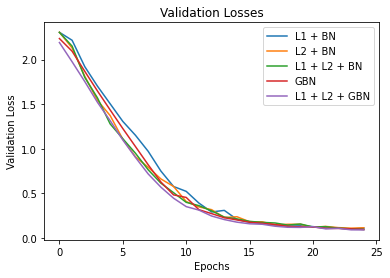

In [30]:
fig, ax = plt.subplots()
for model_version in model_versions:
  ax.plot(train_test_history[model_version]["test_losses"],label=model_version)
  leg = ax.legend()
  
plt.title('Validation Losses')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.savefig(f'{root_path}/validation_loss_plot.png')

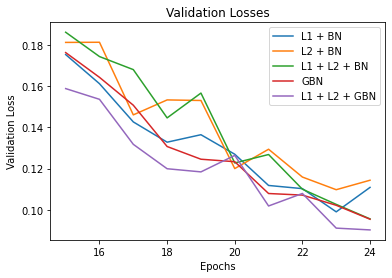

In [31]:
fig, ax = plt.subplots()
for model_version in model_versions:
  after15epochs = train_test_history[model_version]["test_losses"][15:]
  ax.plot([x for x in range(15,25)],after15epochs,label=model_version)
  leg = ax.legend()
  
plt.title('Validation Losses')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.savefig(f'{root_path}/validation_loss_plot_after15epochs.png')

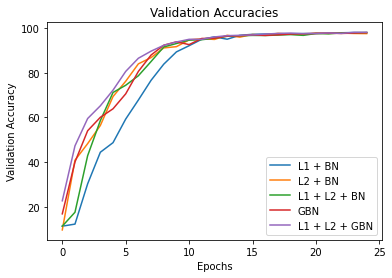

In [32]:
fig, ax = plt.subplots()
for model_version in model_versions:
  ax.plot(train_test_history[model_version]["test_accuracies"],label=model_version)
  leg = ax.legend()
  
plt.title('Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.savefig(f'{root_path}/validation_accuracy_plot.png')

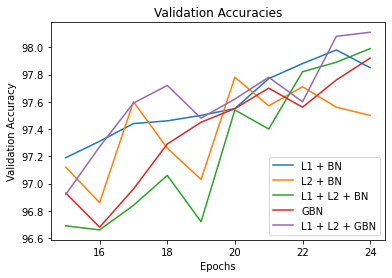

In [33]:
fig, ax = plt.subplots()
for model_version in model_versions:
  after15epochs_acc = train_test_history[model_version]["test_accuracies"][15:]
  ax.plot([x for x in range(15,25)],after15epochs_acc,label=model_version)
  leg = ax.legend()
  
plt.title('Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.savefig(f'{root_path}/validation_accuracy_plot_after15epochs.png')